In [1]:
import os
import cv2
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F

import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
def normalize_image(image):
    # Convert image to float type
    image = image.astype(float)
    # Scale pixel values to range [0, 1]
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) / (image_max - image_min)
    gc.collect()
    return normalized_image

In [3]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    gc.collect()
    return image

In [4]:
def extract_foreground_background_masks(segmentation_map, threshold=10):
    # Load the segmentation map
    seg_map = cv2.imread(segmentation_map, cv2.IMREAD_GRAYSCALE)
    seg_map = cv2.resize(seg_map, (224, 224))

    # Thresholding to create foreground and background masks
    _, foreground_mask = cv2.threshold(seg_map, threshold, 255, cv2.THRESH_BINARY)
    background_mask = cv2.bitwise_not(foreground_mask)

    # Convert masks to NumPy arrays
    foreground_mask_np = np.asarray(foreground_mask)
    background_mask_np = np.asarray(background_mask)
    
    gc.collect()

    return normalize_image(foreground_mask_np), normalize_image(background_mask_np)

In [5]:
class ModifiedResnet(nn.Module):
    def __init__(self, resnet):
        super(ModifiedResnet, self).__init__()
        self.resnet = resnet
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.softmax(x)
        return x

In [6]:
def get_gradcam_map_resnet(model, input_image, target_class=None):
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass
    features = model.conv1(input_image)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)

    features = model.layer1(features)
    features = model.layer2(features)
    features = model.layer3(features)
    features = model.layer4(features)

    # Average pooling to reduce spatial dimensions to 1x1
    pooled_features = nn.functional.adaptive_avg_pool2d(features, 1)
    
    # Compute the gradients of the target class score with respect to the pooled feature maps
    gradients = None
    for param in model.parameters():
        param.requires_grad_(True)
    output = model.fc(pooled_features.view(pooled_features.size(0), -1))
    if target_class is None:
        target_class = output.argmax(dim=1)
    output[:, target_class].backward(retain_graph=True)
    gradients = model.layer4[-1].conv2.weight.grad
    alpha = gradients.mean(dim=(2, 3), keepdim=True)

    # Compute the importance weights for each feature map
    gradcam_map = (alpha * features).sum(dim=1, keepdim=True)
    gradcam_map = nn.functional.relu(gradcam_map)
    
    # Resize the Grad-CAM map to match the input size
    gradcam_map = nn.functional.interpolate(gradcam_map, size=(224, 224), mode='bilinear', align_corners=False)
    
    gc.collect()
    
    return np.mean(gradcam_map.squeeze().cpu().detach().numpy(), axis=0)

In [7]:
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, mobilenet):
        super(ModifiedMobileNetV2, self).__init__()
        self.mobilenet = mobilenet
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.mobilenet(x)
        x = self.softmax(x)
        return x

In [8]:
def get_gradcam_map_mobilenet(model, input_image, target_class=None): 
    activation = {}
    gradient = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    def get_gradient(name):
        def hook(module, grad_input, grad_output):
            gradient[name] = grad_output[0].detach()
        return hook

    model.features[-1].register_forward_hook(get_activation('features'))
    model.features[-1].register_backward_hook(get_gradient('features'))

    model.eval()
    output = model(input_image)
    target_class = torch.argmax(output)

    model.zero_grad()
    output[:, target_class].backward(create_graph=True)
    grads = gradient['features']
    activations = activation['features']

    for i in range(activations.shape[0]):
        activations[i, :] *= grads[i, :]
    grad_cam = torch.mean(activations, dim=1).unsqueeze(0)
    
    gc.collect()
    
    grad_cam = F.relu(grad_cam)
    gradcam_map = nn.functional.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)
    gradcam_map = gradcam_map.squeeze()
    
    gc.collect()
    
    return normalize_image(np.asarray(gradcam_map))

In [9]:
def get_metric_map(model, model_name, input_image, segmentation_path):
    foreground_mask, background_mask = extract_foreground_background_masks(segmentation_path)
    gc.collect()
    
    if model_name == "resnet":
        model = model.eval()
        gradcam_map = get_gradcam_map_resnet(model, input_image)
    elif model_name == "mobilenet":
        model = model.eval()
        gradcam_map = get_gradcam_map_mobilenet(model, input_image)
    else:
        return
    gc.collect()
    
    avg_background = np.mean(background_mask * gradcam_map)
    percentile_value = np.percentile(background_mask * gradcam_map - avg_background, 60)

    fg_image_map = (foreground_mask*gradcam_map- avg_background) > percentile_value
    bg_image_map = ((background_mask*gradcam_map)- avg_background) > percentile_value
    gc.collect()
    
    return fg_image_map, bg_image_map

In [10]:
def get_metric(model, model_name, input_image, segmentation_path):
    fg_map, bg_map = get_metric_map(model, model_name, input_image, segmentation_path)
    fg = np.sum(fg_map)
    bg = np.sum(bg_map)
    gc.collect()
    
    return fg, bg

In [11]:
MODEL_DIR = '/kaggle/input/deeplearning-data'
IMAGE_DIR = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages'
SEGMENT_DIR = '/kaggle/input/pascal-voc-2012/VOC2012/SegmentationObject'

In [12]:
test_list = []
for file in os.listdir(SEGMENT_DIR):
    if file.startswith("2007"):
        test_list.append(file.split('.')[0])
    if len(test_list) == 5:
        break

In [13]:
def get_resnet_performance(test_list):
    model = pickle.load(open(os.path.join(MODEL_DIR, 'teacher.pkl'),'rb'))
    model = model.resnet
    metric = 0 
    for data in test_list:
        image = preprocess_image(os.path.join(IMAGE_DIR,f'{data}.jpg'))
        segmentation_path = os.path.join(SEGMENT_DIR,f'{data}.png')
        fg,bg = get_metric(model, 'resnet', image, segmentation_path)
        metric += fg/(fg+bg)
        gc.collect()
    return metric/len(test_list)

In [14]:
def get_mobilenet_performance(test_list, folder_name, model_name):
    performance = []
    for i in range(1,16):
        model = pickle.load(open(os.path.join(MODEL_DIR, f'{folder_name}/{model_name}{i}.pkl'),'rb'))
        model = model.mobilenet
        metric = 0
        for data in test_list:
            image = preprocess_image(os.path.join(IMAGE_DIR,f'{data}.jpg'))
            segmentation_path = os.path.join(SEGMENT_DIR,f'{data}.png')
            fg,bg = get_metric(model, 'mobilenet', image, segmentation_path)
            metric += fg/(fg+bg)
            gc.collect()
        performance.append(metric/len(test_list))
    return performance

In [15]:
teacher_performance = get_resnet_performance(test_list)

In [16]:
student_performance = get_mobilenet_performance(test_list, 'student', 'mobilenet_vanilla')

In [17]:
KD_performance = get_mobilenet_performance(test_list, 'KD', 'mobilenet_KD')

In [18]:
EKD_performance = get_mobilenet_performance(test_list, 'EKD', 'mobilenet_EKD')

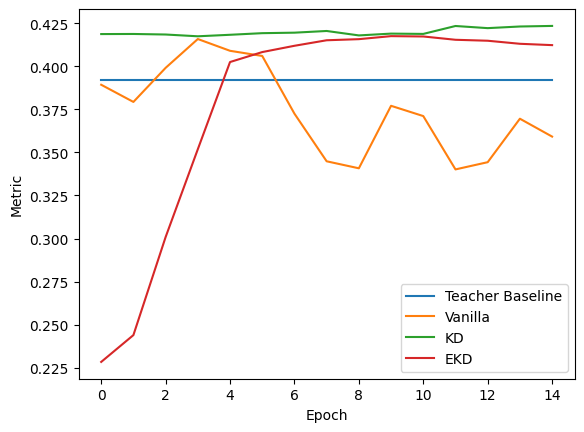

In [19]:
plt.plot(range(15), [teacher_performance for _ in range(15)], label='Teacher Baseline')
plt.plot(range(15), student_performance, label='Vanilla')
plt.plot(range(15), KD_performance, label='KD')
plt.plot(range(15), EKD_performance, label='EKD')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()